![JohnSnowLabs](https://sparknlp.org/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp/blob/master/examples/python/transformers/openvino/HuggingFace_OpenVINO_in_Spark_NLP_SwinForImageClassification.ipynb)

# Import OpenVINO SwinForImageClassification  models from HuggingFace 🤗 into Spark NLP 🚀

This notebook provides a detailed walkthrough on optimizing and exporting BGE models from HuggingFace for use in Spark NLP, leveraging the various tools provided in the [Intel OpenVINO toolkit](https://www.intel.com/content/www/us/en/developer/tools/openvino-toolkit/overview.html) ecosystem.

Let's keep in mind a few things before we start 😊

- OpenVINO support was introduced in  `Spark NLP 5.4.0`, enabling high performance inference for models. Please make sure you have upgraded to the latest Spark NLP release.
- You can import models for SwinForImageClassification  from SwinForImageClassification   and they have to be in `Image Classification` category.

## 1. Export and Save the HuggingFace model

- Let's install `transformers` and `openvino` packages with other dependencies. You don't need `openvino` to be installed for Spark NLP, however, we need it to load and save models from HuggingFace.
- We lock `transformers` on version `4.41.2`. This doesn't mean it won't work with the future releases, but we wanted you to know which versions have been tested successfully.

In [1]:
!pip install -q --upgrade transformers==4.39.3
!pip install -q --upgrade openvino==2024.3
!pip install -q --upgrade optimum-intel==1.18.3
!pip install -q --upgrade onnx==1.12.0
!pip install --upgrade huggingface-hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.4/223.4 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

[Optimum Intel](https://github.com/huggingface/optimum-intel?tab=readme-ov-file#openvino) is the interface between the Transformers library and the various model optimization and acceleration tools provided by Intel. HuggingFace models loaded with optimum-intel are automatically optimized for OpenVINO, while being compatible with the Transformers API.
- To load a HuggingFace model directly for inference/export, just replace the `AutoModelForXxx` class with the corresponding `OVModelForXxx` class. We can use this to import and export OpenVINO models with `from_pretrained` and `save_pretrained`.
- By setting `export=True`, the source model is converted to OpenVINO IR format on the fly.
- We'll use [google/vit-base-patch16-224](https://huggingface.co/google/vit-base-patch16-224) model from HuggingFace, representing an OpenVINO model.
- In addition to the OVModelForFeatureExtraction model, we also need to save the `AutoTokenizer`. This is the same for every model, these are assets (saved in `/assets`) needed for tokenization inside Spark NLP.

In [7]:
from transformers import AutoTokenizer

MODEL_NAME = "microsoft/swin-tiny-patch4-window7-224"
EXPORT_PATH = f"ov_models/{MODEL_NAME}"

! optimum-cli export openvino --model {MODEL_NAME} {EXPORT_PATH}
!mkdir {EXPORT_PATH}/assets

2024-10-19 21:30:10.487788: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-19 21:30:10.515223: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-19 21:30:10.527766: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-19 21:30:11.970971: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
config.json: 100% 71.8k/71.8k [00:00<00:00, 5.78MB/s]
Framework not specified. Using pt to export the model.
model.safetensors: 100% 113M/113M [00:00<00:00, 227MB/s]
Automatic task detection to image-classification.
preprocessor_config.json:

In [8]:
! mv -t {EXPORT_PATH}/assets {EXPORT_PATH}/*.json {EXPORT_PATH}/*.txt

mv: cannot stat 'ov_models/microsoft/swin-tiny-patch4-window7-224/*.txt': No such file or directory


In [9]:
import json

config = open(f"{EXPORT_PATH}/assets/config.json")
model_data = json.load(config)
json_data = json.dumps(model_data['id2label'])
# Let's make sure the id is type int and not string
new_dict = dict()
old_dict = json.loads(json_data)
for k in old_dict:
  v = old_dict[k]
  if type(k) == str:
    k = int(k)
  new_dict[v] = k
json_data = new_dict

# now we can save the labels.json to our assets directory
with open(f'{EXPORT_PATH}/assets/labels.json', 'w') as outfile:
      json.dump(json_data, outfile)
      outfile.write('\n')

In [10]:
!ls -l {EXPORT_PATH}/assets

total 108
-rw-r--r-- 1 root root 70027 Oct 19 21:30 config.json
-rw-r--r-- 1 root root 29552 Oct 19 21:30 labels.json
-rw-r--r-- 1 root root   592 Oct 19 21:30 preprocessor_config.json


## Import and Save SwinForImageClassification in Spark NLP

- Let's install and setup Spark NLP in Google Colab
- This part is pretty easy via our simple script
- Additionally, we need to upgrade Spark to version 3.4.1.

In [ ]:
! wget -q http://setup.johnsnowlabs.com/colab.sh -O - | bash
! pip install -U pyspark==3.4.1

Installing PySpark 3.2.3 and Spark NLP 5.4.2
setup Colab for PySpark 3.2.3 and Spark NLP 5.4.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.5/281.5 MB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 579.5/579.5 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 15.9 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285386 sha256=eeb932a5a27a74de0a0370d2948a7b90dc59fa98578b4fa552ed5d001bf1a6b7
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark
  Attempting uninstall: py4j
    Found exi

Let's start Spark with Spark NLP included via our simple `start()` function

In [ ]:
import sparknlp
# let's start Spark with Spark NLP
spark = sparknlp.start()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 629.6/629.6 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: spark-nlp
    Found existing installation: spark-nlp 5.4.2
    Uninstalling spark-nlp-5.4.2:
      Successfully uninstalled spark-nlp-5.4.2


- Let's use `loadSavedModel` functon in `SwinForImageClassification` which allows us to load the Openvino model
- Most params will be set automatically. They can also be set later after loading the model in `SwinForImageClassification` during runtime, so don't worry about setting them now
- `loadSavedModel` accepts two params, first is the path to the exported model. The second is the SparkSession that is `spark` variable we previously started via `sparknlp.start()`
- NOTE: `loadSavedModel` accepts local paths in addition to distributed file systems such as `HDFS`, `S3`, `DBFS`, etc. This feature was introduced in Spark NLP 4.2.2 release. Keep in mind the best and recommended way to move/share/reuse Spark NLP models is to use `write.save` so you can use `.load()` from any file systems natively.st and recommended way to move/share/reuse Spark NLP models is to use `write.save` so you can use `.load()` from any file systems natively.

In [ ]:
from sparknlp.annotator import *
from sparknlp.base import *

imageClassifier = SwinForImageClassification.loadSavedModel(
     EXPORT_PATH,
     spark
 )\
  .setInputCols(["image_assembler"])\
  .setOutputCol("class")

- Let's save it on disk so it is easier to be moved around and also be used later via `.load` function

In [ ]:
imageClassifier.write().overwrite().save("./{}_spark_nlp".format(EXPORT_PATH))

Awesome  😎 !

This is your Openvino SwinForImageClassification model from HuggingFace 🤗  loaded and saved by Spark NLP 🚀

In [ ]:
! ls -l {MODEL_NAME}_spark_nlp

ls: cannot access 'microsoft/swin-tiny-patch4-window7-224_spark_nlp': No such file or directory


Now let's see how we can use it on other machines, clusters, or any place you wish to use your new and shiny SwinForImageClassification model 😊

--2024-09-07 20:28:11--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/src/test/resources/image/hippopotamus.JPEG
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 147353 (144K) [image/jpeg]
Saving to: ‘hippopotamus.JPEG’

hippopotamus.JPEG   100%[===================>] 143.90K  --.-KB/s    in 0.03s   

2024-09-07 20:28:11 (4.32 MB/s) - ‘hippopotamus.JPEG’ saved [147353/147353]



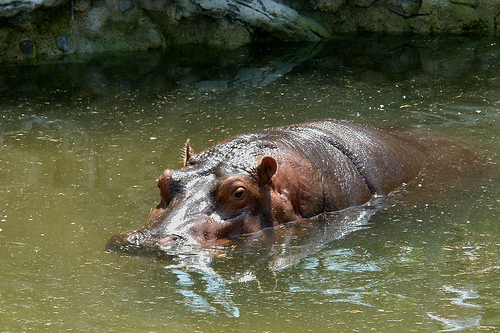

In [ ]:
!wget https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/src/test/resources/image/hippopotamus.JPEG
from IPython.display import Image, display
display(Image("hippopotamus.JPEG"))

In [ ]:
document_assembler = ImageAssembler() \
    .setInputCol("image") \
    .setOutputCol("image_assembler")

imageClassifier_loaded = SwinForImageClassification.load("./{}_spark_nlp".format(EXPORT_PATH))\
  .setInputCols(["image_assembler"])\
  .setOutputCol("class")

pipeline = Pipeline().setStages([
    document_assembler,
    imageClassifier_loaded
])

test_image = spark.read\
    .format("image")\
    .option("dropInvalid", value = True)\
    .load("./hippopotamus.JPEG")

result = pipeline.fit(test_image).transform(test_image)

result.select("class.result").show(1, False)

+----------------------------------------------------------+
|result                                                    |
+----------------------------------------------------------+
|[hippopotamus, hippo, river horse, Hippopotamus amphibius]|
+----------------------------------------------------------+



That's it! You can now go wild and use hundreds of SwinForImageClassification models from HuggingFace 🤗 in Spark NLP 🚀
